## Trajectories of one realization of coevolving binary strings of length 50

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

seq_len = 50

In [2]:
def read_params(path):
    """Read a parameter file"""
    params = dict()
    f = open(path, "r")
    for l in f.readlines():
        try:
            params[l.split()[0]] = float(l.split()[1])
        except ValueError:
            if ',' not in l.split()[1]:
                params[l.split()[0]] = l.split()[1]
            else:
                params[l.split()[0]] = np.array(l.split()[1].split(','), dtype=float)
    f.close()
    return params


def read_traj(path):
    """
    Read an output trajectory of the WF simulation.
    Each line is a time point sampled every traj_step.
    The line is formatted as gnt_id:gnt_abundance,gnt_fitness.
    The output is a dict of genotypes (key) and list of pairs
    composed [time index, abundance] or [time index, fitness]
    """
    f = open(path, "r")
    trajs, fitns = dict(), dict()
    t = 1
    for line in f.readlines():
        for id_ab in line.split('\t'):
            if ':' not in id_ab: continue
            id_, ab_ft = id_ab.split(':')[0], id_ab.split(':')[1]
            ab, ft = int(ab_ft.split(',')[0]), float(ab_ft.split(',')[1])
            if id_ in trajs:
                trajs[id_] = np.row_stack((trajs[id_], [t,ab]))
                fitns[id_] = np.row_stack((fitns[id_], [t,ft]))
            else:
                trajs[id_] = np.array([[t,ab]])
                fitns[id_] = np.array([[t,ft]])
        t += 1
    f.close()
    return trajs, fitns


def read_seqs(path):
    """
    Reading the dictionary associating each gnt_id to the 
    sequence of spins
    """
    f = open(path, "r")
    seqs = dict()
    for line in f.readlines():
        id_ = line.split(':')[0]
        s = -np.ones(seq_len, dtype=int)
        s_up_mask = [c=='+' for c in line.split(':')[1].split('_')[1][:-1]]
        s[s_up_mask] = 1
        seqs[id_] = s
    f.close()
    return seqs


def compute_snp_traj(seqs, trajs_ab, N):
    snps_trajs = np.zeros((seq_len, N))
    for id_ in trajs_ab:
        s = seqs[id_]
        ab = trajs_ab[id_][:,1]
        for it, t in enumerate(trajs_ab[id_][:,0]):
            snp_mask = s==1
            snps_trajs[snp_mask,t-1] += ab[it]
    return snps_trajs
            

def compute_snp_turnover(snps, dt=1):
    t_steps = np.arange(0,len(snps[0]),dt)
    #n_gnt_turn_traj = np.zeros(len(t_steps)+1)
    turnover = np.zeros(len(t_steps)-1)
    for ab_traj in snps:
        ab = ab_traj[t_steps]
        turnover += np.abs(ab[1:]-ab[:-1])
    return turnover

def read_2dtraj(path):
    f = open(path, 'r')
    traj = []
    for line in f.readlines():
        traj.append(line.split('\t')[:-1])
    f.close()
    return np.array(traj, dtype=float)


def smooth_traj(times, traj, window):
    smooth_tr, smooth_times = [], []
    for t in range(len(times)-window):
        smooth_tr.append(traj[t:t+window].mean())
        smooth_times.append(times[t:t+window].mean())
    return smooth_times, smooth_tr

In [52]:
data_dir = 'run1/'
params = read_params(data_dir+'param.txt')
relax_step = 0
print(params)

{'n_realizations': 100.0, 'print_info': 1.0, 'n_init_seq': 10.0, 'n_generations': 10000.0, 'pop_size1': 1000.0, 'pop_size2': 1000.0, 'traj_step': 20.0, 'mut_rate1': 0.00033, 'mut_rate2': 0.00033, 'sel_coef1': 0.01, 'sel_coef2': -0.01, 'turn_long_dts': array([ 20., 100., 500.]), 'seed': 0.0}


In [53]:
# Parsing the abundance trajectories
trajs_ab1, trajs_ft1 = read_traj(data_dir+'trajectory_0.txt')
trajs_ab2, trajs_ft2 = read_traj(data_dir+'trajectory_1.txt')

# Parsing the average fitness trajectories
av_fitness1 = read_2dtraj(data_dir+'av_fitness.txt')[:,0][relax_step:]
av_fitness2 = read_2dtraj(data_dir+'av_fitness.txt')[:,1][relax_step:]

# Parsing the genotype dictionary
seqs1 = read_seqs(data_dir+'gnt_info_0.txt')
seqs2 = read_seqs(data_dir+'gnt_info_1.txt')

# Parsing the turnovers
av_turn_long1, av_turn_long2 = [], []
for dt_long in params['turn_long_dts']:
    dt_long = int(dt_long)
    av_turn_long1.append(read_2dtraj(data_dir+'turnover_'+str(dt_long)+'.txt')[:,0][int(relax_step/dt_long):])
    av_turn_long2.append(read_2dtraj(data_dir+'turnover_'+str(dt_long)+'.txt')[:,1][int(relax_step/dt_long):])

In [54]:
times = np.arange(0,int(params['n_generations'])+1, int(params['traj_step']))
times = times[relax_step:]
mid_times = (times[:-1]+times[1:])/2

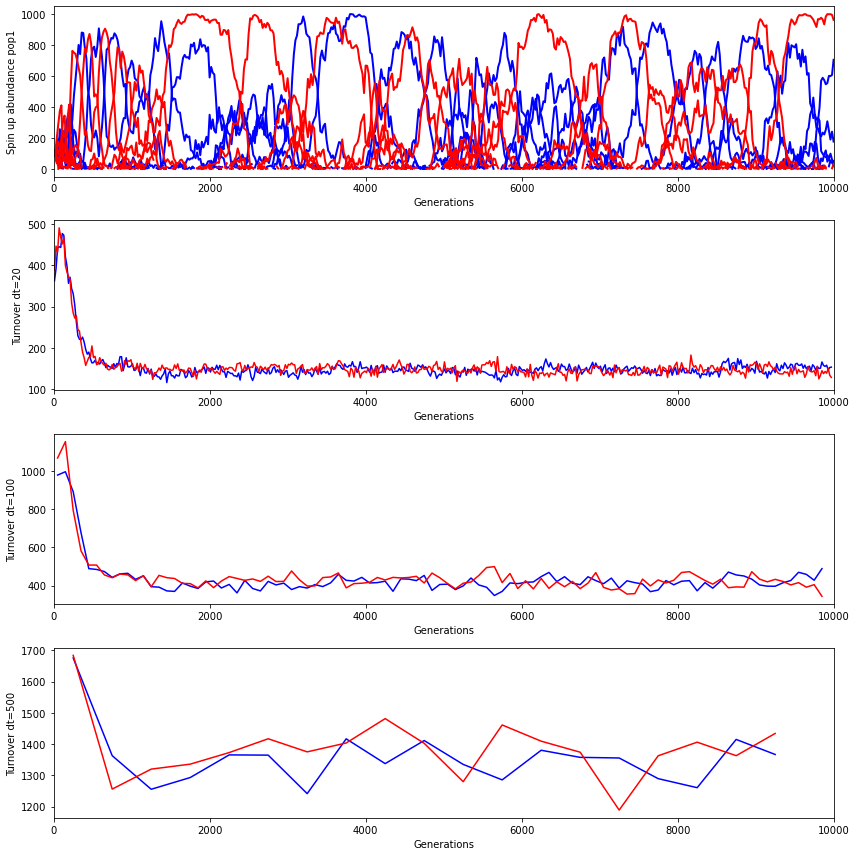

In [55]:
fig, axs = plt.subplots(len(params['turn_long_dts'])+1,1,figsize=(12,12))
c1, c2 = 'b', 'r'

axs[0].set_xlim(times[0], times[-1])
axs[0].set_xlabel('Generations')
axs[0].set_ylabel('Spin up abundance pop1')
for id_, traj in trajs_ab1.items():
    t = traj[:,0]*params['traj_step']-1
    ab = traj[:,1]
    axs[0].plot(t, ab, c=c1, lw=2)
for id_, traj in trajs_ab2.items():
    t = traj[:,0]*params['traj_step']-1
    ab = traj[:,1]
    axs[0].plot(t, ab, c=c2, lw=2)


rhos = []
for i, dt_long in enumerate(params['turn_long_dts']):
    times_long = times[np.arange(0,len(times)-1,int(dt_long/params['traj_step']))][int(relax_step/dt_long):]
    mid_times_long = (times_long[:-1]+times_long[1:])/2
    axs[i+1].set_xlim(times[0], times[-1])
    axs[i+1].set_xlabel('Generations')
    axs[i+1].set_ylabel('Turnover dt=%i'%dt_long)
    axs[i+1].plot(mid_times_long, av_turn_long1[i], c=c1)
    axs[i+1].plot(mid_times_long, av_turn_long2[i], c=c2)
    rhos.append(spearmanr(av_turn_long1[i],av_turn_long2[i])[0])


plt.tight_layout()
#plt.savefig(data_dir+'turnovers.png', dpi=200)